In [11]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

import numpy as np
from datetime import datetime, timedelta

- Load data

In [12]:
file_path_risoe = r'./Data/Risoe/risoe_m_all.nc'
file_paths_borglum = r'./Data/Borglum/borglum_all.nc'

signals_risoe = ['ws77', 'wd77', 'ws125', 'wd125']
signals_borglum = ['ws32', 'wd32']

base_date_borglum = datetime(1997, 12, 11, 16, 5, 0)
base_date_risoe = datetime(1995, 11, 20, 16, 25, 0)

# Get the Risoe dataset:
datasetRI = nc.Dataset(file_path_risoe, 'r')
datasetBO = nc.Dataset(file_paths_borglum, 'r')

time_minutes = np.array(datasetRI.variables['time'])

# Convert time values to timestamp strings
time = []
for minutes in time_minutes:
	time_delta = timedelta(minutes=int(minutes))
	timestamp = base_date_risoe + time_delta
	time.append(timestamp.strftime('%Y-%m-%d %H:%M:%S'))
 
print(f"time:\n {time[:10]} - {time[-1]}")

for signal in signals_risoe:
	values = np.array(datasetRI.variables[signal])
	print(f'{signal}:\n {values[:10]} - {values[-10:-1]}')


time:
 ['1995-11-20 16:25:00', '1995-11-20 16:35:00', '1995-11-20 16:45:00', '1995-11-20 16:55:00', '1995-11-20 17:05:00', '1995-11-20 17:15:00', '1995-11-20 17:25:00', '1995-11-20 17:35:00', '1995-11-20 17:45:00', '1995-11-20 17:55:00'] - 2007-12-31 23:56:00
ws77:
 [3.36 3.05 3.59 3.87 4.74 4.91 4.98 5.39 5.76 5.52] - [8.14 8.71 6.82 7.26 7.24 6.04 6.97 8.17 6.66]
wd77:
 [205. 205. 204. 202. 201. 206. 203. 203. 193. 200.] - [0. 0. 0. 0. 0. 0. 0. 0. 0.]
ws125:
 [3.04 3.17 3.64 3.77 4.28 4.91 5.35 5.58 5.75 5.38] - [nan nan nan nan nan nan nan nan nan]
wd125:
 [208. 214. 209. 209. 212. 213. 210. 206. 207. 205.] - [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:

# List the variables in the dataset
print("(ri)Variables in the netCDF file:")
for var_name in datasetRI.variables:
    print(var_name)


(ri)Variables in the netCDF file:
time
ws44
ws44_qc
ws77
ws77_qc
ws125
ws125_qc
wd77
wd77_qc
wd125
wd125_qc
t003
t003_qc
t044
t044_qc
t118
t118_qc
td01
td01_qc
rain
rain_qc
press
press_qc
rhum
rhum_qc
grad
grad_qc


In [14]:
# List the variables in the dataset
print("(bo)Variables in the netCDF file:")
for var_name in datasetBO.variables:
    print(var_name)

(bo)Variables in the netCDF file:
time
ws32
ws32_qc
ws20
ws20_qc
ws10
ws10_qc
wd10
wd10_qc
wd32
wd32_qc
t002
t002_qc
t30
t30_qc
td10_2
td10_2_qc
td30_10
td30_10_qc
rhum
rhum_qc
grad
grad_qc
press
press_qc


## Process data

- Process data (Meso)

In [15]:
# Load the CSV data into a pandas DataFrame
csv_file = './Data/Risoe/meso_Risoe.csv'
df = pd.read_csv(csv_file)

# Convert the DataFrame to an xarray dataset
dataset = xr.Dataset.from_dataframe(df)

# Save the xarray dataset to a NetCDF file
new_file = 'wind_risoe_meso.nc'
dataset.to_netcdf(new_file)


In [16]:
# choose 80 from meso
# Open the original NetCDF file
dataset = xr.open_dataset('./wind_risoe_meso.nc')

# Select the variables you want
wind_meso = dataset[['TIMESTAMP', 'WSP080', 'WDIR080']]

# Save the new dataset to a new NetCDF file
wind_meso.to_netcdf('wind_meso.nc')

# Close the original dataset
dataset.close()


- Process data (Mast)

In [17]:
print(datasetRI['ws77'][:].mean())
print(datasetRI['wd77'][:].mean())

6.882234418209576
193.13708584271382


In [18]:

# choose height 77 from ri

# Open the original NetCDF file
datasetRI = xr.open_dataset('./Data/Risoe/risoe_m_all.nc')

# Select the variables you want
wind_data = datasetRI[['time', 'ws77', 'wd77']]

# Save the new dataset to a new NetCDF file
wind_data.to_netcdf('wind_data.nc')

# Close the original dataset
datasetRI.close()

In [19]:
# choose wd77 from ri
# replace negative wind speed
wind_data['ws77'][:][wind_data['ws77'][:] < 0] = 7
# replace unsuitable wind direction
wind_data['wd77'][:][wind_data['ws77'][:] < 0] = 193
wind_data['wd77'][:][wind_data['ws77'][:] > 360] = 193

- tip: wind_data -> mast , wind_meso -> meso

- Convert time (mast)

In [20]:
# Assuming 'time' is the variable representing time in DK time
# Define the time zone offset for DK time (e.g., UTC+1)
dk_offset = 2

# Convert the time variable to UTC
time_utc = wind_data['time'] - dk_offset

# Update the 'time' variable in the dataset
wind_data['time'] = time_utc

# Enable time decoding for the updated 'time' variable
wind_data['time'].attrs['units'] = 'hours since 1970-01-01 00:00:00'


- Resample the mast dataset to have the same frequency as the meso data

In [21]:
# Resample the "mast" dataset to an hourly frequency
wind_data_1h = wind_data.resample(time='1H').mean()

In [22]:
wind_data_1h['time']

<xarray.DataArray 'time' (time: 106184)>
array(['1995-11-20T16:00:00.000000000', '1995-11-20T17:00:00.000000000',
       '1995-11-20T18:00:00.000000000', ..., '2007-12-31T21:00:00.000000000',
       '2007-12-31T22:00:00.000000000', '2007-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1995-11-20T16:00:00 ... 2007-12-31T23:00:00
Attributes:
    units:    hours since 1970-01-01 00:00:00

In [23]:
# Mast
# Define the start and end times
start_time = '2001-06-10T15:00:00'
end_time = '2007-12-31T23:00:00'

# Use .sel() to select the time range
wind_data_1h = wind_data_1h.sel(time=slice(start_time, end_time))

## Exploratory analysis

In [24]:
# wind speeed between 2002-2003
# Initialize an empty DataFrame to store the combined data
wind_data_1h_df = wind_data_1h.to_dataframe()

wind_data_1h_df

,ws77,wd77
time,,
2001-06-10 15:00:00,1.620000,333.000000
2001-06-10 16:00:00,1.780000,338.833333
2001-06-10 17:00:00,2.023333,350.833333
2001-06-10 18:00:00,1.918333,140.166667
2001-06-10 19:00:00,3.928333,112.333333
...,...,...
2007-12-31 19:00:00,6.366667,0.000000
2007-12-31 20:00:00,8.723333,0.000000
2007-12-31 21:00:00,8.430000,0.000000


In [25]:
wind_data_1h_df.dropna()

,ws77,wd77
time,,
2001-06-10 15:00:00,1.620000,333.000000
2001-06-10 16:00:00,1.780000,338.833333
2001-06-10 17:00:00,2.023333,350.833333
2001-06-10 18:00:00,1.918333,140.166667
2001-06-10 19:00:00,3.928333,112.333333
...,...,...
2007-12-31 19:00:00,6.366667,0.000000
2007-12-31 20:00:00,8.723333,0.000000
2007-12-31 21:00:00,8.430000,0.000000


<Axes: xlabel='time'>

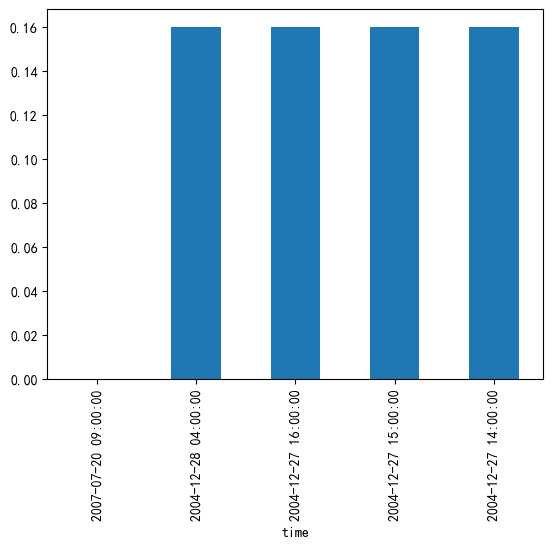

In [26]:
# head 5 wind speed
wind_data_1h_df['ws77'].sort_values().head(5).plot.bar()

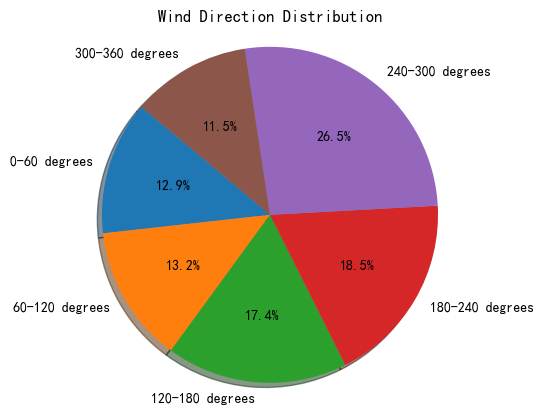

In [27]:
# Create the labels for the pie chart
labels = ['0-60 degrees', '60-120 degrees', '120-180 degrees', '180-240 degrees', '240-300 degrees', '300-360 degrees']

# Define the ranges for your groups
ranges = [0, 60, 120, 180, 240, 300, 360]

# Create a histogram of 'wd77' within the specified ranges
hist, bins = np.histogram(wind_data_1h_df['wd77'], bins=ranges)

# Create a pie chart
plt.pie(hist, labels=labels, autopct='%1.1f%%', startangle=140, shadow=True)

# Set the title
plt.title('Wind Direction Distribution')

# Display the pie chart
plt.axis('equal')
plt.show()

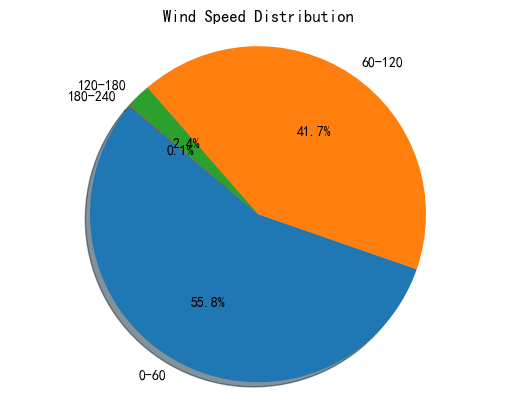

In [29]:
# Determine the range for 'ws77' automatically
ws77_min = wind_data_1h_df['ws77'].min()
ws77_max = wind_data_1h_df['ws77'].max()

# Define the number of groups
num_groups = 4

# Create labels for the pie chart based on value ranges
labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(num_groups)]

# Create a histogram of 'ws77' with automatic binning
hist, bins = np.histogram(wind_data_1h_df['ws77'], bins=num_groups, range=(ws77_min, ws77_max))

# Create a pie chart
plt.pie(hist, labels=labels, autopct='%1.1f%%', startangle=140, shadow=True)

# Set the title
plt.title('Wind Speed Distribution')

# Display the pie chart
plt.axis('equal')
plt.show()


C:\Users\fhuur\AppData\Local\Temp\ipykernel_17404\160379046.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(direction_labels)


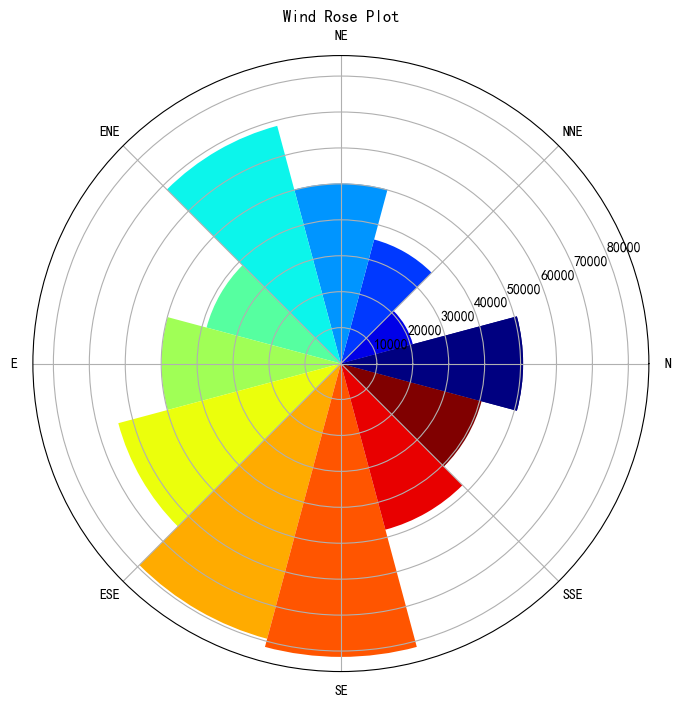

In [30]:
# Create a wind rose plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Bin wind directions into 12 sectors
n = 12
wind_directions = np.deg2rad(wind_data['wd77'])
bins = np.linspace(0, 2 * np.pi, n + 1)

hist, _ = np.histogram(wind_directions, bins=bins)
hist = np.concatenate((hist, [hist[0]]))  # Close the circle

# Set wind direction labels as cardinal directions
direction_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
ax.set_xticklabels(direction_labels)

# Create a colormap based on wind direction
cmap = ListedColormap(plt.cm.jet(np.linspace(0, 1, n)))

# Plot the wind rose with different colors for each sector
ax.bar(bins, hist, width=bins[1] - bins[0], bottom=0.0, color=cmap(range(n)))

# Set the title
plt.title('Wind Rose Plot')

plt.show()

## Model Development & Evaluation

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [32]:
# Open the NetCDF4 file
nc_file = nc.Dataset('./wind_data.nc', 'r')
nc_file2 = nc.Dataset('./wind_data_meso.nc', 'r')

# Extract data for "mast" and "meso" groups (replace variable names with actual variable names in your data)
mast_ws77 = nc_file.variables['ws77'][:]
mast_wd77 = nc_file.variables['wd77'][:]
meso_ws77 = nc_file2.variables['WSP080'][:]
meso_wd77 = nc_file2.variables['WDIR080'][:]

# Create DataFrames for "mast" and "meso" groups
mast_df = pd.DataFrame({'ws77': mast_ws77, 'wd77': mast_wd77})
meso_df = pd.DataFrame({'ws77': meso_ws77, 'wd77': meso_wd77})

# Drop rows with NaN (missing) values in DataFrames
mast_df.dropna(subset=['ws77', 'wd77'], inplace=True)
meso_df.dropna(subset=['ws77', 'wd77'], inplace=True)

# Regression analysis for "mast" group
X_mast = mast_df['wd77'].values.reshape(-1, 1)
y_mast = mast_df['ws77'].values
X_train_mast, X_test_mast, y_train_mast, y_test_mast = train_test_split(X_mast, y_mast, test_size=0.2, random_state=42)

model_mast = LinearRegression()
model_mast.fit(X_train_mast, y_train_mast)
y_pred_mast = model_mast.predict(X_test_mast)

mse_mast = mean_squared_error(y_test_mast, y_pred_mast)
r2_mast = r2_score(y_test_mast, y_pred_mast)

# Print and compare the results
print("Mast Group:")
print(f'Mean Squared Error: {mse_mast}')
print(f'R-squared (R^2): {r2_mast}')

Mast Group:
Mean Squared Error: 10.754692550358508
R-squared (R^2): 0.006768272449934165


In [33]:
# Regression analysis for "meso" group
X_meso = meso_df['wd77'].values.reshape(-1, 1)
y_meso = meso_df['ws77'].values
X_train_meso, X_test_meso, y_train_meso, y_test_meso = train_test_split(X_meso, y_meso, test_size=0.2, random_state=42)

model_meso = LinearRegression()
model_meso.fit(X_train_meso, y_train_meso)
y_pred_meso = model_meso.predict(X_test_meso)

mse_meso = mean_squared_error(y_test_meso, y_pred_meso)
r2_meso = r2_score(y_test_meso, y_pred_meso)

# Print the results for "meso" group
print("Meso Group:")
print(f'Mean Squared Error: {mse_meso}')
print(f'R-squared (R^2): {r2_meso}')

Meso Group:
Mean Squared Error: 9.580961448734737
R-squared (R^2): 0.004586354463221531


In [34]:
# Initialize and train the Linear Regression model for "mast" group
model_mast = LinearRegression()

# Perform K-fold cross-validation for "mast" group
mast_cross_val_scores = cross_val_score(model_mast, X_mast, y_mast, cv=5)  # You can adjust the number of folds (cv) as needed

# Initialize and train the Linear Regression model for "meso" group
model_meso = LinearRegression()

# Perform K-fold cross-validation for "meso" group
meso_cross_val_scores = cross_val_score(model_meso, X_meso, y_meso, cv=5)  # You can adjust the number of folds (cv) as needed

# Print and compare the cross-validation results
print("Mast Group Cross-Validation Scores:")
print(mast_cross_val_scores)
print(f"Mean R-squared (R^2) for Mast Group: {np.mean(mast_cross_val_scores)}")

print("Meso Group Cross-Validation Scores:")
print(meso_cross_val_scores)
print(f"Mean R-squared (R^2) for Meso Group: {np.mean(meso_cross_val_scores)}")


Mast Group Cross-Validation Scores:
[ 0.00619594  0.01035385  0.00584101  0.00723173 -0.00088899]
Mean R-squared (R^2) for Mast Group: 0.005746707990585432
Meso Group Cross-Validation Scores:
[0.00542443 0.00300402 0.00096327 0.00196092 0.0076299 ]
Mean R-squared (R^2) for Meso Group: 0.003796506310018
